# Neural Network

## Importing Libraries

In [316]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics as metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.model_selection import train_test_split 

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier

In [317]:
from sklearn.metrics import roc_curve, auc
import seaborn as sns
import itertools

In [318]:
# import pandas as pd
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense
# from scikeras.wrappers import KerasClassifier
# from sklearn.model_selection import cross_val_score
# from sklearn.preprocessing import LabelEncoder
# from sklearn.model_selection import StratifiedKFold
# from sklearn.preprocessing import StandardScaler
# from sklearn.pipeline import Pipeline
# import keras
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.layers import LeakyReLU,PReLU,ELU
# from keras.layers import Dropout

## Loading Dataset

In [319]:
df = pd.read_csv('heart.csv')
data = df.to_numpy()

In [320]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [321]:
X = data[:, :-1]
# y = data[:, -1]
y = data[:, -1].reshape((-1,1))

## **Data Preprocessing**
### Spliting Dataset

We split our dataaset into 60% training set and 40% testing set. Then we further split the training set into 70% training and 30% validation set

In [322]:
# Split data into training and testing sets (60% training, 40% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Further split training data into training and validation sets (70% training, 30% validation)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)


In [323]:
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)

X_train shape: (126, 13)
X_val shape: (55, 13)
X_test shape: (122, 13)
y_train shape: (126, 1)
y_val shape: (55, 1)
y_test shape: (122, 1)


### Scaling Data

In [324]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

# Transform validation and testing data using the scaler fitted on the training data
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

## **Implementation Of Neural Network Using Pytorch**

In [325]:
%conda install -c pytorch pytorch torchvision

Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.




==> WARNING: A newer version of conda exists. <==
  current version: 23.7.4
  latest version: 24.4.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=24.4.0




In [326]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn import Linear, BCELoss
from torch.optim import SGD
import matplotlib.pyplot as plt

### Convert numpy arrays to PyTorch tensors

In [327]:
X_train_tensor = torch.Tensor(X_train)
y_train_tensor = torch.Tensor(y_train)
X_test_tensor = torch.Tensor(X_test)
y_test_tensor = torch.Tensor(y_test)
X_val_tensor = torch.Tensor(X_val)
y_val_tensor = torch.Tensor(y_val)

### Defining Neural Network Class

In [328]:
def get_act_fn(act_fn):
    if act_fn == 'relu':
        return F.relu
    elif act_fn == 'sigmoid':
        return F.sigmoid
    elif act_fn == 'tanh':
        return F.tanh
    raise ValueError


class Model(nn.Module):
    def __init__(self, n_feature, n_hidden_layers, n_hidden, n_output, activation='sigmoid', out_activation='sigmoid'):
        super(Model, self).__init__()

        # Activation functions
        self.activation = get_act_fn(activation)
        self.output_activation = get_act_fn(out_activation)

        # Neural Network Structure
        self.n_hidden_layers = n_hidden_layers
        self.hidden_layers = nn.ModuleList()
        self.hidden_layers.append(nn.Linear(n_feature, n_hidden))
        for _ in range(n_hidden_layers - 1):
            self.hidden_layers.append(nn.Linear(n_hidden, n_hidden))
        self.output_layer = nn.Linear(n_hidden, n_output)

    def forward(self, x):
        for layer in self.hidden_layers:
            x = self.activation(layer(x))
        x = self.output_activation(self.output_layer(x))
        return x

## **Training Our Neural Network Model**

### Training with default Sigmoid activation function first

In [329]:
train_model = Model(X_train.shape[1], 1, 8, 1)
loss_cal = BCELoss(reduction='mean')

### Optimization with Stochastic Gradient Descent

In [330]:
def optimize(num_epoch, optimizer, model, X_tensor, y_tensor):
    epoch_loss_dict = {}
    for epoch in range(num_epoch):                    
        y_pred = model(X_tensor)                    # Forward propagation
        loss = loss_cal(y_pred, y_tensor)           # Compute lost
        epoch_loss_dict[epoch] = loss.item()
        optimizer.zero_grad()                       # Zero the gradients
        loss.backward()                             # Backward propagation
        optimizer.step()                            # Update the parameters

    return y_pred, epoch_loss_dict


num_epoch = 10000
optimizer = SGD(train_model.parameters(), lr=0.01)

y_pred_train, epoch_loss_dict_train = optimize(num_epoch, optimizer, train_model, X_train_tensor, y_train_tensor)

In [331]:
y_pred_binary_train = (y_pred_train.detach().numpy() > 0.5).astype(int)

### **Training Results**

#### Performance Metrics

In [332]:
def perf_metrics(y, y_pred_binary):
    accuracy = accuracy_score(y, y_pred_binary)
    precision = precision_score(y, y_pred_binary)
    recall = recall_score(y, y_pred_binary)
    f1 = f1_score(y, y_pred_binary)
    return accuracy, precision, recall, f1


accuracy_train, precision_train, recall_train, f1_train = perf_metrics(y_train, y_pred_binary_train)
print("Accuracy on training set:", accuracy_train)
print("Precision on training set:", precision_train)
print("Recall on training set:", recall_train)
print("F1-score on training set:", f1_train)

Accuracy on training set: 0.9126984126984127
Precision on training set: 0.9076923076923077
Recall on training set: 0.921875
F1-score on training set: 0.9147286821705427


#### Plotting Loss Curve

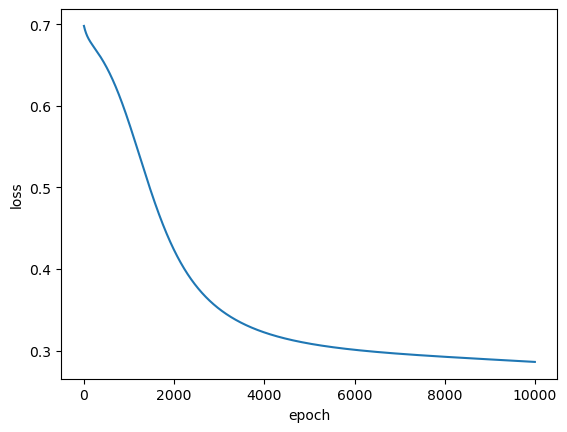

In [333]:
def plot_loss_curve(epoch_loss_dict):
    plt.figure()
    plt.plot(epoch_loss_dict.keys(), epoch_loss_dict.values())
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.show()

plot_loss_curve(epoch_loss_dict_train)

#### Confusion Matrix

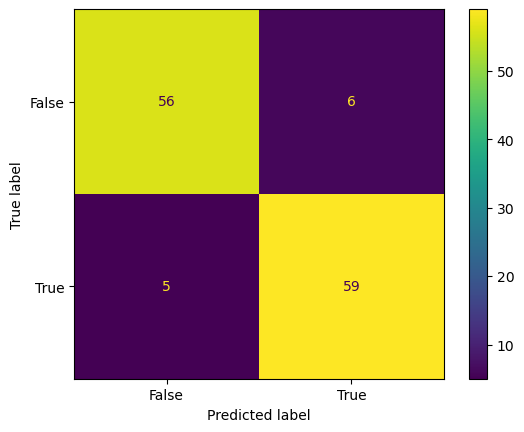

In [334]:
def confusion_matrix(y, y_pred_binary):
    cm = metrics.confusion_matrix(y, y_pred_binary)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])
    cm_display.plot()
    plt.show()


confusion_matrix(y_train, y_pred_binary_train)

## **Trying Our Model on Validation Set**

In [335]:
y_pred_val = train_model(X_val_tensor)
y_pred_binary_val = (y_pred_val.detach().numpy() > 0.5).astype(int)

### Performance Metrics

In [336]:
accuracy_val, precision_val, recall_val, f1_val = perf_metrics(y_val, y_pred_binary_val)

print("Accuracy on validation set:", accuracy_val)
print("Precision on validation set:", precision_val)
print("Recall on validation set:", recall_val)
print("F1-score on validation set:", f1_val)

Accuracy on validation set: 0.7818181818181819
Precision on validation set: 0.8275862068965517
Recall on validation set: 0.7741935483870968
F1-score on validation set: 0.7999999999999999


### Confusion Matrix

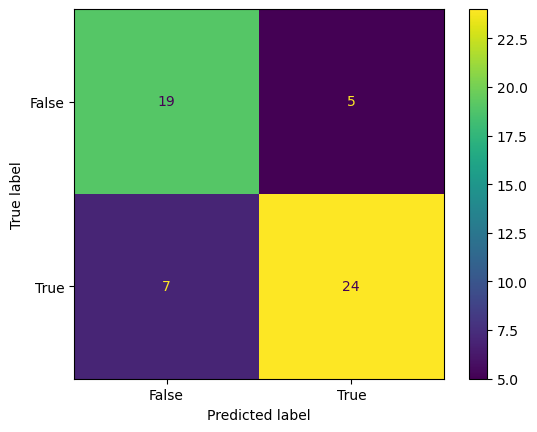

In [337]:
confusion_matrix(y_val, y_pred_binary_val)

### **Adding Regularization**

#### **L2 Regularization**

In [338]:
# Define the optimizer with L2 regularization (weight decay)
lambda_l2 = 1e-2
optimizer_reg_l2 = SGD(train_model.parameters(), lr=0.01, weight_decay = lambda_l2)

def optimize_l2(num_epoch, lambda_l2, optimizer, model, X_tensor, y_tensor):
    epoch_loss_dict = {}
    for epoch in range(num_epoch):                    
        y_pred = model(X_tensor)                    # Forward propagation
        loss = loss_cal(y_pred, y_tensor)           # Compute original lost
        # Add L2 regularization term to the loss
        loss += lambda_l2 * sum(torch.norm(param) ** 2 for param in model.parameters())  
        epoch_loss_dict[epoch] = loss.item()
        optimizer.zero_grad()                       # Zero the gradients
        loss.backward()                             # Backward propagation
        optimizer.step()                            # Update the parameters

    return y_pred, epoch_loss_dict

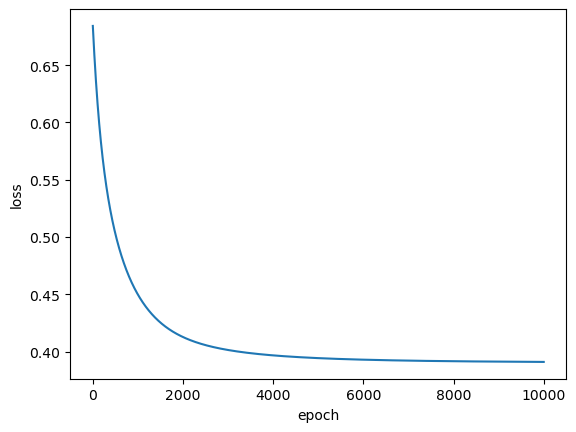

In [339]:
y_pred_val_reg_l2, epoch_loss_dict_val_reg_l2 = optimize_l2(num_epoch, lambda_l2, optimizer_reg_l2, train_model, X_val_tensor, y_val_tensor)
y_pred_binary_val_reg_l2 = (y_pred_val_reg_l2.detach().numpy() > 0.5).astype(int)
plot_loss_curve(epoch_loss_dict_val_reg_l2)

In [340]:
accuracy_val_l2, precision_val_l2, recall_val_l2, f1_val_l2 = perf_metrics(y_val, y_pred_binary_val_reg_l2)

print("Accuracy on validation set with L2 regularization:", accuracy_val_l2)
print("Precision on validation set with L2 regularization:", precision_val_l2)
print("Recall on validation set with L2 regularization:", recall_val_l2)
print("F1-score on validation set with L2 regularization:", f1_val_l2)

Accuracy on validation set with L2 regularization: 0.9090909090909091
Precision on validation set with L2 regularization: 0.90625
Recall on validation set with L2 regularization: 0.9354838709677419
F1-score on validation set with L2 regularization: 0.9206349206349206


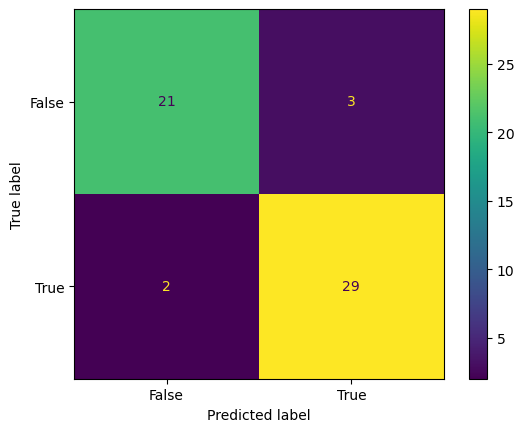

In [341]:
confusion_matrix(y_val, y_pred_binary_val_reg_l2)

#### Finding the best lambda2

In [342]:
lambda_lst = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0]
best_accuracy_l2 = 0
best_lambda2 = 0

for lambda_l2 in lambda_lst:
    optimizer_reg_l2 = SGD(train_model.parameters(), lr=0.01, weight_decay = lambda_l2)
    y_pred_reg_l2, epoch_loss_dict_reg_l2 = optimize_l2(num_epoch, lambda_l2, optimizer_reg_l2, train_model, X_val_tensor, y_val_tensor)
    y_pred_binary_reg_l2 = (y_pred_reg_l2.detach().numpy() > 0.5).astype(int)
    accuracy_l2, precision_l2, recall_l2, f1_l2 = perf_metrics(y_val, y_pred_binary_reg_l2)
    if accuracy_l2 > best_accuracy_l2:
        best_accuracy_l2 = accuracy_l2
        best_lambda2 = lambda_l2
    print("Lambda2: {}, Accuracy: {}".format(lambda_l2, accuracy_l2))

print("Best lambda2: {} with accuracy = {}".format(best_lambda2, best_accuracy_l2))

Lambda2: 1e-05, Accuracy: 0.9818181818181818
Lambda2: 0.0001, Accuracy: 1.0
Lambda2: 0.001, Accuracy: 1.0
Lambda2: 0.01, Accuracy: 0.9090909090909091
Lambda2: 0.1, Accuracy: 0.5636363636363636
Lambda2: 1.0, Accuracy: 0.5636363636363636
Best lambda2: 0.0001 with accuracy = 1.0


#### **L1 Regularization**

In [343]:
# Define the optimizer with L1 regularization
lambda_l1 = 1e-2
optimizer_reg_l1 = SGD(train_model.parameters(), lr=0.01, weight_decay = lambda_l1)


def optimize_l1(num_epoch, lambda_l1, optimizer, model, X_tensor, y_tensor):
    epoch_loss_dict = {}
    for epoch in range(num_epoch):                    
        y_pred = model(X_tensor)                    # Forward propagation
        loss = loss_cal(y_pred, y_tensor)           # Compute original lost

        # Add L1 regularization term to the loss
        l1_reg = 0
        for param in model.parameters():
            l1_reg += torch.norm(param, p=1)
        l1_penalty = lambda_l1 * l1_reg

        # Compute total loss with L1 regularization
        loss = loss_cal(y_pred, y_tensor) + l1_penalty 
        epoch_loss_dict[epoch] = loss.item()

        optimizer.zero_grad()                       # Zero the gradients
        loss.backward()                             # Backward propagation
        optimizer.step()                            # Update the parameters

    return y_pred, epoch_loss_dict

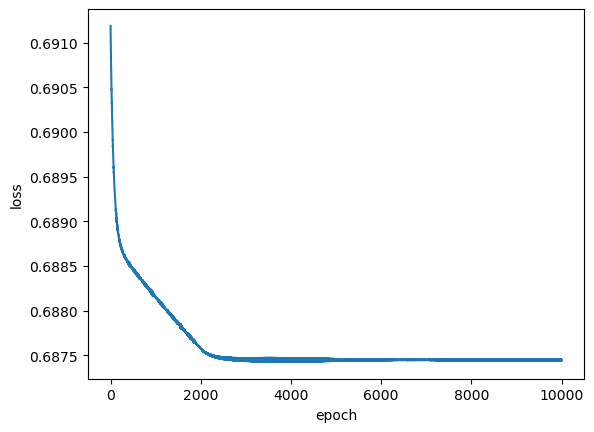

In [344]:
y_pred_val_reg_l1, epoch_loss_dict_val_reg_l1 = optimize_l1(num_epoch, lambda_l1, optimizer_reg_l1, train_model, X_val_tensor, y_val_tensor)
y_pred_binary_val_reg_l1 = (y_pred_val_reg_l1.detach().numpy() > 0.5).astype(int)
plot_loss_curve(epoch_loss_dict_val_reg_l1)

In [345]:
accuracy_val_l1, precision_val_l1, recall_val_l1, f1_val_l1 = perf_metrics(y_val, y_pred_binary_val_reg_l1)

print("Accuracy on validation set with L2 regularization:", accuracy_val_l1)
print("Precision on validation set with L2 regularization:", precision_val_l1)
print("Recall on validation set with L2 regularization:", recall_val_l1)
print("F1-score on validation set with L2 regularization:", f1_val_l1)

Accuracy on validation set with L2 regularization: 0.5636363636363636
Precision on validation set with L2 regularization: 0.5636363636363636
Recall on validation set with L2 regularization: 1.0
F1-score on validation set with L2 regularization: 0.7209302325581396


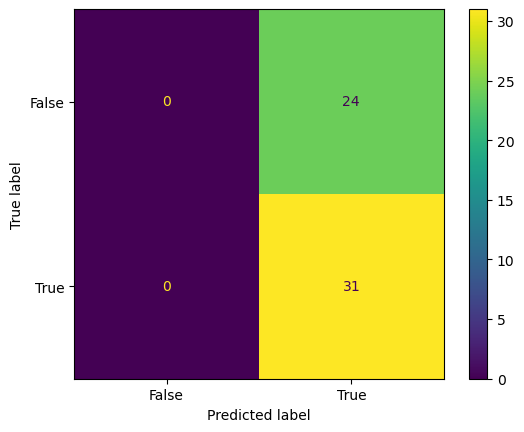

In [346]:
confusion_matrix(y_val, y_pred_binary_val_reg_l1)

#### Finding the best lambda1

In [347]:
best_accuracy_l1 = 0
best_lambda1 = 0

for lambda_l1 in lambda_lst:
    optimizer_reg_l1 = SGD(train_model.parameters(), lr=0.01, weight_decay = lambda_l1)
    y_pred_reg_l1, epoch_loss_dict_reg_l1 = optimize_l1(num_epoch, lambda_l1, optimizer_reg_l1, train_model, X_val_tensor, y_val_tensor)
    y_pred_binary_reg_l1 = (y_pred_reg_l1.detach().numpy() > 0.5).astype(int)
    accuracy_l1, precision_l1, recall_l1, f1_l1 = perf_metrics(y_val, y_pred_binary_reg_l1)
    if accuracy_l1 > best_accuracy_l1:
        best_accuracy_l1 = accuracy_l1
        best_lambda1 = lambda_l1
    print("Lambda1: {}, Accuracy: {}".format(lambda_l1, accuracy_l1))

print("Best lambda1: {} with accuracy = {}".format(best_lambda1, best_accuracy_l1))

Lambda1: 1e-05, Accuracy: 0.9090909090909091
Lambda1: 0.0001, Accuracy: 0.9818181818181818
Lambda1: 0.001, Accuracy: 0.9818181818181818
Lambda1: 0.01, Accuracy: 0.8727272727272727


c:\Users\vnmt1\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Lambda1: 0.1, Accuracy: 0.43636363636363634
Lambda1: 1.0, Accuracy: 0.5636363636363636
Best lambda1: 0.0001 with accuracy = 0.9818181818181818


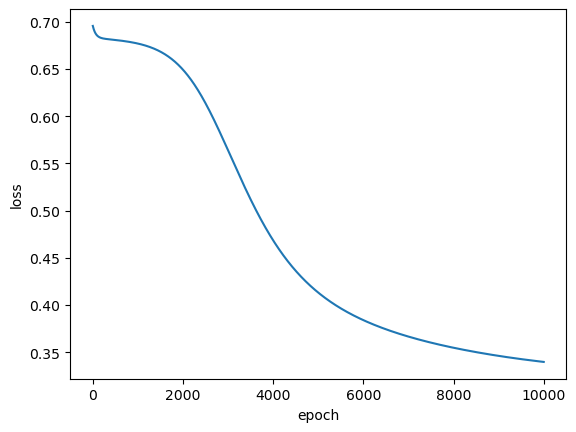

Accuracy on test set with L2 regularization: 0.860655737704918
Precision on test set with L2 regularization: 0.8441558441558441
Recall on test set with L2 regularization: 0.9285714285714286
F1-score on test set with L2 regularization: 0.8843537414965986


In [348]:
# Define the optimizer with L2 regularization (weight decay)
best_lambda = 0.0001
optimizer_reg = SGD(train_model.parameters(), lr=0.01, weight_decay = best_lambda)

y_pred_test_reg_l2, epoch_loss_dict_test_reg_l2 = optimize_l2(num_epoch, best_lambda, optimizer_reg, train_model, X_test_tensor, y_test_tensor)
y_pred_binary_test_reg_l2 = (y_pred_test_reg_l2.detach().numpy() > 0.5).astype(int)
plot_loss_curve(epoch_loss_dict_test_reg_l2)

accuracy_test_l2, precision_test_l2, recall_test_l2, f1_test_l2 = perf_metrics(y_test, y_pred_binary_test_reg_l2)

print("Accuracy on test set with L2 regularization:", accuracy_test_l2)
print("Precision on test set with L2 regularization:", precision_test_l2)
print("Recall on test set with L2 regularization:", recall_test_l2)
print("F1-score on test set with L2 regularization:", f1_test_l2)

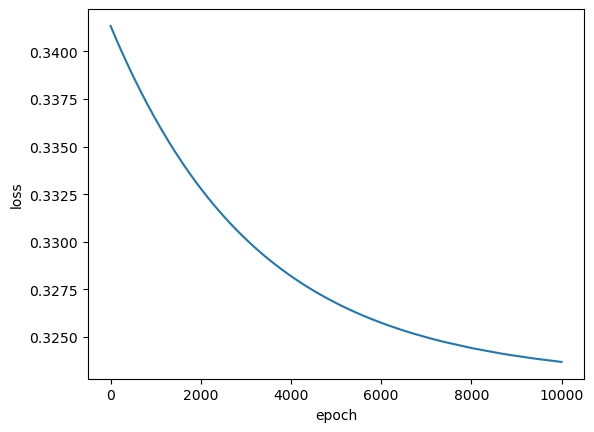

Accuracy on test set with L1 regularization: 0.8524590163934426
Precision on test set with L1 regularization: 0.8611111111111112
Recall on test set with L1 regularization: 0.8857142857142857
F1-score on test set with L1 regularization: 0.8732394366197184


In [349]:
y_pred_test_reg_l1, epoch_loss_dict_test_reg_l1 = optimize_l1(num_epoch, best_lambda, optimizer_reg, train_model, X_test_tensor, y_test_tensor)
y_pred_binary_test_reg_l1 = (y_pred_test_reg_l1.detach().numpy() > 0.5).astype(int)
plot_loss_curve(epoch_loss_dict_test_reg_l1)

accuracy_test_l1, precision_test_l1, recall_test_l1, f1_test_l1 = perf_metrics(y_test, y_pred_binary_test_reg_l1)

print("Accuracy on test set with L1 regularization:", accuracy_test_l1)
print("Precision on test set with L1 regularization:", precision_test_l1)
print("Recall on test set with L1 regularization:", recall_test_l1)
print("F1-score on test set with L1 regularization:", f1_test_l1)

### **Hyperparameter Tuning using Grid Search**

In [350]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_hidden_layers': [2, 3, 4],
    'learning_rate': [0.1, 0.01, 0.001, 0.0001, 0.00001],
    'act_fns': ['relu', 'sigmoid', 'tanh']
}


# Define hyperparameters to search
hidden_layers_list = [1, 2, 3, 4]
learning_rates = [0.1, 0.01, 0.001, 0.0001, 0.00001]
activations =  ['relu', 'sigmoid', 'tanh']

# Define a function to create and train the model with given hyperparameters
def train_model(hidden_layers, learning_rate, activation, X_train, y_train, X_val, y_val):
    train_model = Model(n_feature=X_train.shape[1], n_hidden_layers=hidden_layers, n_hidden=8, n_output=1, activation=activation)
    optimizer = torch.optim.SGD(train_model.parameters(), lr=learning_rate)
    loss_function = nn.BCELoss()

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

    num_epochs = 1000
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        outputs = train_model(X_train_tensor)
        loss = loss_function(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
    
    # Evaluation on validation set
    with torch.no_grad():
        outputs_val = train_model(X_val_tensor)
        predictions_val = (outputs_val > 0.5).float()
        accuracy_val = (predictions_val == y_val_tensor).sum().item() / len(y_val_tensor)

    return accuracy_val

# Perform grid search
best_accuracy = 0
best_params = {}
for hidden_layers, learning_rate, activation in itertools.product(hidden_layers_list, learning_rates, activations):
    accuracy = train_model(hidden_layers, learning_rate, activation, X_train, y_train, X_val, y_val)
    print("hidden_layers: {}, learning_rate: {}, activation: {}".format(hidden_layers, learning_rate, activation))
    print("Accuracy:", accuracy)
    print("============================")
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params['hidden_layers'] = hidden_layers
        best_params['learning_rate'] = learning_rate
        best_params['activation'] = activation

print("Best parameters:", best_params)
print("Best accuracy:", best_accuracy)


hidden_layers: 1, learning_rate: 0.1, activation: relu
Accuracy: 0.7454545454545455
hidden_layers: 1, learning_rate: 0.1, activation: sigmoid
Accuracy: 0.7818181818181819
hidden_layers: 1, learning_rate: 0.1, activation: tanh
Accuracy: 0.6545454545454545
hidden_layers: 1, learning_rate: 0.01, activation: relu
Accuracy: 0.8363636363636363
hidden_layers: 1, learning_rate: 0.01, activation: sigmoid
Accuracy: 0.7454545454545455
hidden_layers: 1, learning_rate: 0.01, activation: tanh
Accuracy: 0.8181818181818182
hidden_layers: 1, learning_rate: 0.001, activation: relu
Accuracy: 0.6909090909090909
hidden_layers: 1, learning_rate: 0.001, activation: sigmoid
Accuracy: 0.5636363636363636
hidden_layers: 1, learning_rate: 0.001, activation: tanh
Accuracy: 0.7636363636363637
hidden_layers: 1, learning_rate: 0.0001, activation: relu
Accuracy: 0.38181818181818183
hidden_layers: 1, learning_rate: 0.0001, activation: sigmoid
Accuracy: 0.45454545454545453
hidden_layers: 1, learning_rate: 0.0001, activa